## **Import package**


In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

## **Load data && Analysis**


In [3]:
data_train = pd.read_csv("./train.csv")
data_test = pd.read_csv("./test.csv")
sample_submission = pd.read_csv("./sample_submission.csv")

In [4]:
print(data_train.shape)
print(data_train)
data_train.describe()

(42000, 785)
       label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pixel8  ...  pixel7

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


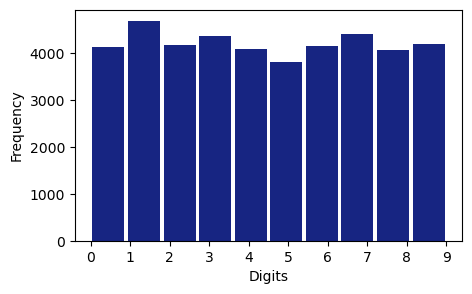

In [5]:
data_train['label'].value_counts()

plt.figure(figsize=(5, 3))
plt.hist(data_train['label'], bins=10,
         density=False, rwidth=0.9, color='#172582')
plt.ylabel('Frequency')
plt.xlabel('Digits')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.show()

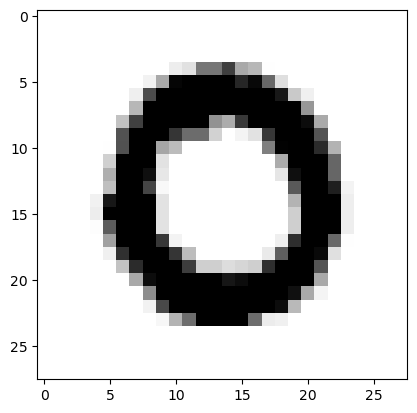

In [9]:
def plot_img(index, data=data_train):
    data = data.copy()
    data.drop('label', axis=1, inplace=True)
    img = data.iloc[index].to_numpy()
    img = img.reshape((28, 28))

    plt.imshow(img, cmap='binary')
    plt.show()


plot_img(1, data_train)

## **Split data**


In [20]:
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

X = data_train.drop('label', axis=1)
Y = data_train['label']

X = torch.FloatTensor(np.array(X))
Y = torch.tensor(np.array(Y))
Y = F.one_hot(Y, 10).type_as(torch.FloatTensor())

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=66)

## **Dataset**


In [21]:
class MnistDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx].reshape((1, 28, 28))
        label = self.labels[idx]

        if self.transform:
            sample = np.array(sample)
            # 因Albumentations圖像格式是 (高度, 寬度, 通道數)，所以使用 sample = sample.reshape((28, 28, 1))
            sample = sample.reshape((28, 28, 1))
            sample = self.transform(image=sample)['image']

        return sample, label

### **Image augmentation**


In [22]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform_train = A.Compose([
    A.RandomScale(scale_limit=0.1, p=0.3),
    A.Rotate(limit=0.1, p=0.2),
    A.Resize(height=28, width=28, p=1.0),
    A.Normalize(mean=(0.1307,), std=(0.3081,), p=1.0),
    ToTensorV2(p=1.0)
])

transform_test = A.Compose([
    A.Normalize(mean=(0.1307,), std=(0.3081,)),
    ToTensorV2()
])

## **Dataloader**


In [23]:
BATCH_SIZE = 32

# Creating datasets
train_dataset = MnistDataset(X_train, Y_train, transform=transform_train)
test_dataset = MnistDataset(X_test, Y_test, transform=transform_test)

# Creating data loaders, drop_last：當資料不足時是否丟棄最後一個batch
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

## **Model**


In [24]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)

        # 我們需要將這個多維的特徵圖扁平化成一個一維數組，以便輸入到全連接層。
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # 1*28*28 經過conv1 32*24*24
        x = F.relu(self.conv1(x))
        # 32*24*24 經過conv2 32*20*20 經過max_pool2 32*10*10
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        # 32*10*10 經過conv2 64*6*6 經過max_pool3 64*3*3
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

## **Train**


In [25]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = NN().to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [26]:
EPOCHS = 20
batch_losses = []
batch_accuracy = []

for epoch in tqdm(range(EPOCHS)):
    for iteration, (X_batch, y_batch) in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()

        output = model(X_batch.to(DEVICE))
        loss = loss_fn(output, y_batch.to(DEVICE))
        batch_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        if (iteration % 200 == 0):
            print(f'Iteration: {iteration}, loss: {loss:4f}')

    for iteration, (X_batch, y_batch) in enumerate(test_dataloader):
        model.eval()

        with torch.no_grad():
            output = model(X_batch.to(DEVICE))

        correct = 0
        correct += (torch.max(output, 1)
                    [1] == torch.max(y_batch, 1)[1].to(DEVICE)).sum().item()
        accuracy = correct / (len(X_batch))
        batch_accuracy.append(accuracy)


train_losses = np.array(batch_losses).reshape(EPOCHS, -1).mean(axis=1)
val_accuracy = np.array(batch_accuracy).reshape(EPOCHS, -1).mean(axis=1)

  0%|          | 0/20 [00:00<?, ?it/s]

Iteration: 0, loss: 2.272246
Iteration: 200, loss: 0.412128
Iteration: 400, loss: 0.186529
Iteration: 600, loss: 0.164516
Iteration: 800, loss: 0.276324
Iteration: 1000, loss: 0.008772


  5%|▌         | 1/20 [00:46<14:42, 46.44s/it]

Iteration: 0, loss: 0.177738
Iteration: 200, loss: 0.282623
Iteration: 400, loss: 0.171916
Iteration: 600, loss: 0.050303
Iteration: 800, loss: 0.038072
Iteration: 1000, loss: 0.020895


 10%|█         | 2/20 [01:31<13:39, 45.52s/it]

Iteration: 0, loss: 0.050489
Iteration: 200, loss: 0.670694
Iteration: 400, loss: 0.024951
Iteration: 600, loss: 0.062962
Iteration: 800, loss: 0.021411
Iteration: 1000, loss: 0.290943


 15%|█▌        | 3/20 [02:16<12:49, 45.26s/it]

Iteration: 0, loss: 0.082765
Iteration: 200, loss: 0.143126
Iteration: 400, loss: 0.103862
Iteration: 600, loss: 0.351544
Iteration: 800, loss: 0.189214
Iteration: 1000, loss: 0.153113


 20%|██        | 4/20 [03:00<12:00, 45.03s/it]

Iteration: 0, loss: 0.036425
Iteration: 200, loss: 0.091892
Iteration: 400, loss: 0.027085
Iteration: 600, loss: 0.033705
Iteration: 800, loss: 0.081188
Iteration: 1000, loss: 0.179816


 25%|██▌       | 5/20 [03:46<11:20, 45.36s/it]

Iteration: 0, loss: 0.006936
Iteration: 200, loss: 0.112250
Iteration: 400, loss: 0.334550
Iteration: 600, loss: 0.067049
Iteration: 800, loss: 0.104640
Iteration: 1000, loss: 0.012393


 30%|███       | 6/20 [04:38<11:07, 47.65s/it]

Iteration: 0, loss: 0.089240
Iteration: 200, loss: 0.157755
Iteration: 400, loss: 0.004127
Iteration: 600, loss: 0.057805
Iteration: 800, loss: 0.159166
Iteration: 1000, loss: 0.097578


 35%|███▌      | 7/20 [05:22<10:01, 46.29s/it]

Iteration: 0, loss: 0.083473
Iteration: 200, loss: 0.091577
Iteration: 400, loss: 0.097259
Iteration: 600, loss: 0.421610
Iteration: 800, loss: 0.109729
Iteration: 1000, loss: 0.005908


 40%|████      | 8/20 [06:05<09:02, 45.18s/it]

Iteration: 0, loss: 0.005802
Iteration: 200, loss: 0.055104
Iteration: 400, loss: 0.051864
Iteration: 600, loss: 0.041424
Iteration: 800, loss: 0.073698
Iteration: 1000, loss: 0.001478


 45%|████▌     | 9/20 [06:48<08:10, 44.60s/it]

Iteration: 0, loss: 0.031450
Iteration: 200, loss: 0.051388
Iteration: 400, loss: 0.022656
Iteration: 600, loss: 0.064757
Iteration: 800, loss: 0.099914
Iteration: 1000, loss: 0.016209


 50%|█████     | 10/20 [07:31<07:20, 44.06s/it]

Iteration: 0, loss: 0.395401
Iteration: 200, loss: 0.039114
Iteration: 400, loss: 0.225489
Iteration: 600, loss: 0.062320
Iteration: 800, loss: 0.213501
Iteration: 1000, loss: 0.004134


 55%|█████▌    | 11/20 [08:14<06:34, 43.79s/it]

Iteration: 0, loss: 0.006475
Iteration: 200, loss: 0.063553
Iteration: 400, loss: 0.120855
Iteration: 600, loss: 0.079117
Iteration: 800, loss: 0.034422
Iteration: 1000, loss: 0.002261


 60%|██████    | 12/20 [08:57<05:48, 43.58s/it]

Iteration: 0, loss: 0.039857
Iteration: 200, loss: 0.002927
Iteration: 400, loss: 0.018351
Iteration: 600, loss: 0.013221
Iteration: 800, loss: 0.005308
Iteration: 1000, loss: 0.002842


 65%|██████▌   | 13/20 [09:40<05:03, 43.37s/it]

Iteration: 0, loss: 0.019705
Iteration: 200, loss: 0.443928
Iteration: 400, loss: 0.007230
Iteration: 600, loss: 0.047982
Iteration: 800, loss: 0.001710
Iteration: 1000, loss: 0.000811


 70%|███████   | 14/20 [10:24<04:21, 43.51s/it]

Iteration: 0, loss: 0.202745
Iteration: 200, loss: 0.045857
Iteration: 400, loss: 0.142436
Iteration: 600, loss: 0.042405
Iteration: 800, loss: 0.003237
Iteration: 1000, loss: 0.009311


 75%|███████▌  | 15/20 [11:08<03:38, 43.65s/it]

Iteration: 0, loss: 0.028270
Iteration: 200, loss: 0.059454
Iteration: 400, loss: 0.041125
Iteration: 600, loss: 0.024816
Iteration: 800, loss: 0.002558
Iteration: 1000, loss: 0.011938


 80%|████████  | 16/20 [11:52<02:55, 43.87s/it]

Iteration: 0, loss: 0.006289
Iteration: 200, loss: 0.019380
Iteration: 400, loss: 0.176047
Iteration: 600, loss: 0.096339
Iteration: 800, loss: 0.163066
Iteration: 1000, loss: 0.119163


 85%|████████▌ | 17/20 [12:38<02:13, 44.41s/it]

Iteration: 0, loss: 0.124233
Iteration: 200, loss: 0.151289
Iteration: 400, loss: 0.001557
Iteration: 600, loss: 0.002415
Iteration: 800, loss: 0.012499
Iteration: 1000, loss: 0.003366


 90%|█████████ | 18/20 [13:27<01:31, 45.74s/it]

Iteration: 0, loss: 0.037408
Iteration: 200, loss: 0.074958
Iteration: 400, loss: 0.001449
Iteration: 600, loss: 0.097734
Iteration: 800, loss: 0.137803
Iteration: 1000, loss: 0.028597


 95%|█████████▌| 19/20 [14:13<00:45, 45.86s/it]

Iteration: 0, loss: 0.073001
Iteration: 200, loss: 0.034463
Iteration: 400, loss: 0.002054
Iteration: 600, loss: 0.057055
Iteration: 800, loss: 0.004102
Iteration: 1000, loss: 0.001994


100%|██████████| 20/20 [14:56<00:00, 44.84s/it]


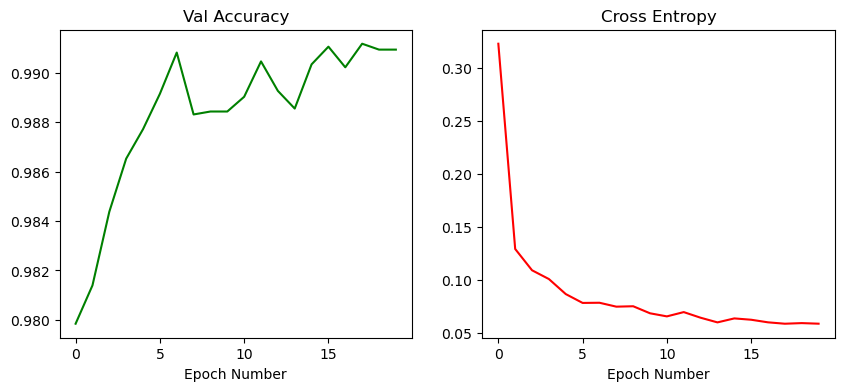

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), val_accuracy, c='g')
plt.xlabel('Epoch Number')
plt.title('Val Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), train_losses, c='r')
plt.xlabel('Epoch Number')
plt.title('Cross Entropy')

plt.show()

## **Prediction**


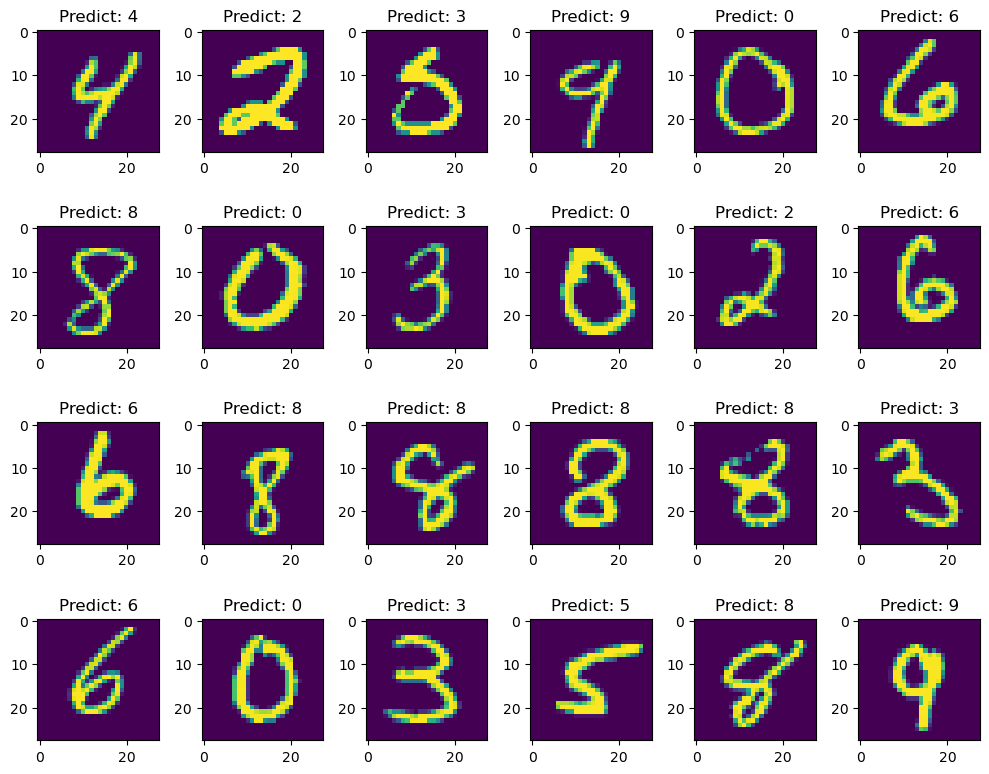

In [28]:
rows = 4
columns = 6

fig, ax = plt.subplots(rows, columns, figsize=(10, 8))

for i in range(rows*columns):
    x, y = test_dataset[i]
    with torch.no_grad():
        y_pred = model(x.unsqueeze(0).to(DEVICE)).argmax(axis=1)
    plt.subplot(rows, columns, i+1)
    plt.imshow(x.squeeze(0))
    plt.title(f'Predict: {y_pred[0]}')

fig.tight_layout()
plt.show()

## **Save**


In [29]:
sample_submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [30]:
submission_data = torch.FloatTensor(
    np.array(data_test)).view(28000, 1, 28, 28).to(DEVICE)

predicts = model(submission_data)
labels = np.array(torch.max(predicts, 1)[1].cpu())

In [31]:
submission = sample_submission.copy()
submission['Label'] = labels
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [32]:
# Save submission file
submission.to_csv('submission.csv', index=False)